In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline 
import seaborn as sns
from xgboost import XGBRegressor, XGBRFRegressor, plot_importance, plot_tree
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

from convertdate import indian_civil
ind_cal = indian_civil.from_gregorian(2020, 100, 25)
from calendar import monthcalendar, SATURDAY, SUNDAY
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')


## Let me read the data files

In [2]:
train_df = pd.read_csv('train_fwYjLYX.csv')
train_df.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [3]:
test_df = pd.read_csv('test_1eLl9Yf.csv')
test_df.head()

,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [4]:
sample_submission_df = pd.read_csv('sample_submission_IIzFVsf.csv')
sample_submission_df.head()

,id,application_date,segment,case_count
0,1,2019-07-06,1,5
1,2,2019-07-07,1,5
2,3,2019-07-08,1,5
3,4,2019-07-09,1,5
4,5,2019-07-10,1,5


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null object
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.7+ MB


In [6]:
##Let me check for the null values before the date conversion
train_df[train_df['application_date'].isnull()]

,application_date,segment,branch_id,state,zone,case_count


In [7]:
train_df['application_date'] = pd.to_datetime( train_df['application_date'],  format='%Y-%m-%d')
test_df['application_date'] = pd.to_datetime( test_df['application_date'],  format='%Y-%m-%d')

## Inspite of all efforts the score has not increased significantly so I am planning to add NIFTY 500 index data obtained from "https://www1.nseindia.com/products/content/equities/indices/historical_index_data.htm"

In [8]:
nifty_500_y17_df = pd.read_csv('NIFTY500_Y17.csv')
nifty_500_y18_df = pd.read_csv('NIFTY500_Y18.csv')
nifty_500_y19_df = pd.read_csv('NIFTY500_Y19.csv')

In [9]:
nifty_500_y17_df.head(10)

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,02-Jan-2017,7007.40,7014.15,6955.45,7002.50,602244980,12181.31
1,03-Jan-2017,7019.00,7048.00,6989.00,7028.75,627404023,13925.83
2,04-Jan-2017,7042.25,7058.60,7024.20,7030.75,800039712,15722.25
3,05-Jan-2017,7063.15,7112.60,7061.80,7106.90,827121928,17180.08
4,06-Jan-2017,7119.05,7140.25,7073.50,7083.10,702347838,16488.64
5,09-Jan-2017,7099.55,7101.75,7076.85,7085.15,576555922,12978.61
6,10-Jan-2017,7108.35,7136.05,7106.45,7132.20,667841272,15963.38
7,11-Jan-2017,7163.90,7220.35,7160.35,7214.15,824933514,19505.41
8,12-Jan-2017,7225.35,7244.20,7209.10,7231.85,786924484,16498.40
9,13-Jan-2017,7268.95,7271.00,7202.95,7228.30,676587382,16755.44


In [10]:
nifty_500_y18_df.head(10)

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,01-Jan-2018,9500.20,9518.90,9421.70,9434.50,2171735968,22625.76
1,02-Jan-2018,9474.10,9487.80,9377.30,9417.85,2065375329,25787.49
2,03-Jan-2018,9455.55,9483.35,9424.10,9439.35,1576728062,26590.52
3,04-Jan-2018,9468.10,9511.85,9441.90,9505.75,1874416120,28786.25
4,05-Jan-2018,9536.75,9577.30,9529.95,9573.45,2006289691,31475.27
5,08-Jan-2018,9608.15,9645.75,9606.50,9639.25,1577796110,29971.89
6,09-Jan-2018,9661.10,9669.45,9607.70,9640.75,1590169011,29096.27
7,10-Jan-2018,9655.75,9658.80,9593.50,9630.60,1557613787,29338.81
8,11-Jan-2018,9635.90,9669.30,9614.65,9650.30,1385662650,28407.94
9,12-Jan-2018,9681.85,9689.75,9583.20,9665.20,1648586794,30735.84


In [11]:
nifty_500_y19_df.head(10)

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,01-Jan-2019,9186.70,9206.05,9128.40,9197.90,724662248,16992.99
1,02-Jan-2019,9169.70,9195.25,9065.45,9103.40,1109343017,27083.35
2,03-Jan-2019,9106.65,9130.00,9006.75,9014.80,992708044,25850.17
3,04-Jan-2019,9034.25,9064.85,8978.20,9054.90,1181698697,26746.32
4,07-Jan-2019,9117.20,9136.30,9064.65,9081.15,985071768,23345.65
5,08-Jan-2019,9090.80,9109.10,9052.10,9098.65,976173837,24758.67
6,09-Jan-2019,9143.20,9149.35,9050.15,9127.45,1101309246,28243.89
7,10-Jan-2019,9132.80,9144.00,9102.55,9119.40,907528784,22642.16
8,11-Jan-2019,9130.70,9142.30,9057.15,9098.20,861743777,23305.01
9,14-Jan-2019,9102.40,9102.90,9014.95,9051.45,911936194,23759.25


In [12]:
nifty500_df = pd.concat([nifty_500_y17_df, nifty_500_y18_df, nifty_500_y19_df], axis=0)
nifty500_df.head(20)

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,02-Jan-2017,7007.40,7014.15,6955.45,7002.50,602244980,12181.3
1,03-Jan-2017,7019.00,7048.00,6989.00,7028.75,627404023,13925.8
2,04-Jan-2017,7042.25,7058.60,7024.20,7030.75,800039712,15722.2
3,05-Jan-2017,7063.15,7112.60,7061.80,7106.90,827121928,17180.1
4,06-Jan-2017,7119.05,7140.25,7073.50,7083.10,702347838,16488.6
5,09-Jan-2017,7099.55,7101.75,7076.85,7085.15,576555922,12978.6
6,10-Jan-2017,7108.35,7136.05,7106.45,7132.20,667841272,15963.4
7,11-Jan-2017,7163.90,7220.35,7160.35,7214.15,824933514,19505.4
8,12-Jan-2017,7225.35,7244.20,7209.10,7231.85,786924484,16498.4
9,13-Jan-2017,7268.95,7271.00,7202.95,7228.30,676587382,16755.4


## NIFTY rows will not be available for the weekends and holidays. I will just duplicate the previous day record for the holidays and weekends

In [13]:
nifty500_df['Date'] = pd.to_datetime( nifty500_df['Date'],  format='%d-%b-%Y')
nifty500_df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,2017-01-02,7007.40,7014.15,6955.45,7002.50,602244980,12181.3
1,2017-01-03,7019.00,7048.00,6989.00,7028.75,627404023,13925.8
2,2017-01-04,7042.25,7058.60,7024.20,7030.75,800039712,15722.2
3,2017-01-05,7063.15,7112.60,7061.80,7106.90,827121928,17180.1
4,2017-01-06,7119.05,7140.25,7073.50,7083.10,702347838,16488.6


In [14]:
nifty500_df = (nifty500_df.set_index(['Date', nifty500_df.groupby('Date').cumcount()])
                .unstack(1, fill_value='')
                .reindex(pd.date_range(nifty500_df['Date'].min(), nifty500_df['Date'].max()))
                .ffill()
                .replace('', np.nan)
                .stack(1)
                .reset_index(level=1, drop=True)
                .rename_axis('Date').reset_index())

nifty500_df = nifty500_df.rename(columns = {'Date' : 'application_date' , 'Close': 'nse500_index', 'Turnover (Rs. Cr)': 'Turnover'})

In [15]:
nifty500_df.head(16)

,application_date,Open,High,Low,nse500_index,Shares Traded,Turnover
0,2017-01-02,7007.40,7014.15,6955.45,7002.50,602244980,12181.3
1,2017-01-03,7019.00,7048.00,6989.00,7028.75,627404023,13925.8
2,2017-01-04,7042.25,7058.60,7024.20,7030.75,800039712,15722.2
3,2017-01-05,7063.15,7112.60,7061.80,7106.90,827121928,17180.1
4,2017-01-06,7119.05,7140.25,7073.50,7083.10,702347838,16488.6
5,2017-01-07,7119.05,7140.25,7073.50,7083.10,702347838,16488.6
6,2017-01-08,7119.05,7140.25,7073.50,7083.10,702347838,16488.6
7,2017-01-09,7099.55,7101.75,7076.85,7085.15,576555922,12978.6
8,2017-01-10,7108.35,7136.05,7106.45,7132.20,667841272,15963.4
9,2017-01-11,7163.90,7220.35,7160.35,7214.15,824933514,19505.4


In [16]:
nifty500_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 7 columns):
application_date    1094 non-null datetime64[ns]
Open                1094 non-null float64
High                1094 non-null float64
Low                 1094 non-null float64
nse500_index        1094 non-null float64
Shares Traded       1094 non-null object
Turnover            1094 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 59.9+ KB


In [17]:
nifty500_df['Turnover'] = pd.to_numeric(nifty500_df['Turnover'], errors='coerce')

## Leat me check the unique states

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.7+ MB


In [19]:
train_df.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


## Now let mecheck and remove the null values if any

In [20]:
train_df[train_df['application_date'].isnull()]

,application_date,segment,branch_id,state,zone,case_count


In [21]:
train_df[train_df['segment'].isnull()]

,application_date,segment,branch_id,state,zone,case_count


In [22]:
train_df[train_df['branch_id'].isnull()].head()

,application_date,segment,branch_id,state,zone,case_count
66898,2017-04-01,2,NaN,ASSAM,NaN,0.0
66899,2017-04-02,2,NaN,ASSAM,NaN,0.0
66900,2017-04-03,2,NaN,ASSAM,NaN,0.0
66901,2017-04-04,2,NaN,ASSAM,NaN,0.0
66902,2017-04-05,2,NaN,ASSAM,NaN,0.0


In [23]:
train_df[train_df['zone'].isnull()].head()

,application_date,segment,branch_id,state,zone,case_count
66898,2017-04-01,2,NaN,ASSAM,NaN,0.0
66899,2017-04-02,2,NaN,ASSAM,NaN,0.0
66900,2017-04-03,2,NaN,ASSAM,NaN,0.0
66901,2017-04-04,2,NaN,ASSAM,NaN,0.0
66902,2017-04-05,2,NaN,ASSAM,NaN,0.0


In [24]:
train_df[train_df['zone'].isnull()].head()

,application_date,segment,branch_id,state,zone,case_count
66898,2017-04-01,2,NaN,ASSAM,NaN,0.0
66899,2017-04-02,2,NaN,ASSAM,NaN,0.0
66900,2017-04-03,2,NaN,ASSAM,NaN,0.0
66901,2017-04-04,2,NaN,ASSAM,NaN,0.0
66902,2017-04-05,2,NaN,ASSAM,NaN,0.0


## This is the time for EDA. Let us check the data

### We have null values but I am planning to group by the data based on date and segment. So null value treatment is not required as we dont have null values for date and zone columns

In [25]:
#Let us check all the unique states
train_df.state.unique()

array(['WEST BENGAL', 'DELHI', 'KARNATAKA', 'TAMIL NADU', 'UTTAR PRADESH',
       'PUNJAB', 'TELANGANA', 'ANDHRA PRADESH', 'MAHARASHTRA', 'ORISSA',
       'GUJARAT', 'ASSAM', 'JHARKHAND', 'UTTARAKHAND', 'KERALA',
       'CHHATTISGARH', 'BIHAR', 'TRIPURA', 'MADHYA PRADESH', 'HARYANA'],
      dtype=object)

In [26]:
train_df[train_df['segment'] == 1].state.unique()

array(['WEST BENGAL', 'DELHI', 'KARNATAKA', 'TAMIL NADU', 'UTTAR PRADESH',
       'PUNJAB', 'TELANGANA', 'ANDHRA PRADESH', 'MAHARASHTRA', 'ORISSA',
       'GUJARAT', 'ASSAM', 'JHARKHAND', 'UTTARAKHAND', 'KERALA',
       'CHHATTISGARH', 'BIHAR', 'TRIPURA', 'MADHYA PRADESH', 'HARYANA'],
      dtype=object)

In [27]:
train_df[train_df['segment'] == 2].state.unique()

array(['ASSAM', 'BIHAR', 'CHHATTISGARH', 'GUJARAT', 'HARYANA',
       'JHARKHAND', 'KERALA', 'KARNATAKA', 'MAHARASHTRA',
       'MADHYA PRADESH', 'ORISSA', 'PUNJAB', 'TAMIL NADU', 'TRIPURA',
       'UTTAR PRADESH', 'WEST BENGAL'], dtype=object)

In [28]:
#Let me check the data for a single date

train_df[train_df['application_date'] == '2017-04-01']


,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
806,2017-04-01,1,3.0,DELHI,NORTH,58.0
1612,2017-04-01,1,5.0,KARNATAKA,SOUTH,10.0
2418,2017-04-01,1,7.0,WEST BENGAL,EAST,2.0
3224,2017-04-01,1,8.0,WEST BENGAL,EAST,13.0
4030,2017-04-01,1,9.0,WEST BENGAL,EAST,11.0
4836,2017-04-01,1,10.0,WEST BENGAL,EAST,0.0
5642,2017-04-01,1,11.0,WEST BENGAL,EAST,9.0
6448,2017-04-01,1,13.0,TAMIL NADU,SOUTH,1.0
7254,2017-04-01,1,14.0,UTTAR PRADESH,EAST,0.0


In [29]:
train_df.shape

(80402, 6)

## Let me check for the major states contributing for the loan cases and check for the festivals for sales campaigns.

In [30]:
train_df['year'] = train_df['application_date'].dt.year
train_df['day'] = train_df['application_date'].dt.day
train_df['month'] = train_df['application_date'].dt.month
train_df['day_of_week'] = train_df['application_date'].dt.dayofweek
train_df.head()

train_states_df = train_df.groupby(['state', 'year','month'])['case_count'].sum()
train_states_df.sort_values()

state           year  month
HARYANA         2018  2             0.0
                2017  5             0.0
                      6             0.0
                      7             0.0
                      8             0.0
                      9             0.0
                      10            0.0
                      11            0.0
                      4             0.0
                      12            0.0
                2018  3             0.0
                      4             0.0
                      1             0.0
                      5            10.0
                      6            93.0
ANDHRA PRADESH  2019  7           175.0
HARYANA         2019  7           224.0
                2018  7           232.0
ANDHRA PRADESH  2017  11          260.0
                      4           270.0
                      7           288.0
                      5           299.0
                      8           300.0
                2018  5           305.0
            

In [31]:
train_states_df = train_df.groupby(['state', 'year', 'month'])['case_count'].sum()
train_states_df.sort_values()

state           year  month
HARYANA         2018  2             0.0
                2017  5             0.0
                      6             0.0
                      7             0.0
                      8             0.0
                      9             0.0
                      10            0.0
                      11            0.0
                      4             0.0
                      12            0.0
                2018  3             0.0
                      4             0.0
                      1             0.0
                      5            10.0
                      6            93.0
ANDHRA PRADESH  2019  7           175.0
HARYANA         2019  7           224.0
                2018  7           232.0
ANDHRA PRADESH  2017  11          260.0
                      4           270.0
                      7           288.0
                      5           299.0
                      8           300.0
                2018  5           305.0
            

In [32]:
train_states_df = train_df.groupby(['state', 'year'])['case_count'].sum()
train_states_df.sort_values()

state           year
HARYANA         2017          0.0
ANDHRA PRADESH  2017       3375.0
HARYANA         2018       4729.0
UTTARAKHAND     2017       6220.0
ANDHRA PRADESH  2019       6700.0
                2018       6935.0
HARYANA         2019       7319.0
JHARKHAND       2017       9715.0
UTTARAKHAND     2019      10914.0
TRIPURA         2017      11399.0
PUNJAB          2017      16094.0
TELANGANA       2019      16461.0
                2017      20181.0
PUNJAB          2019      20229.0
UTTARAKHAND     2018      22815.0
DELHI           2017      27673.0
PUNJAB          2018      36536.0
DELHI           2019      45454.0
TRIPURA         2019      47510.0
UTTAR PRADESH   2017      49698.0
BIHAR           2017      51737.0
TELANGANA       2018      53877.0
DELHI           2018      62673.0
JHARKHAND       2019      64201.0
ASSAM           2017      69950.0
CHHATTISGARH    2017      71480.0
                2019      71761.0
UTTAR PRADESH   2019      93148.0
JHARKHAND       2018      9

In [33]:
train_states_df = train_df.groupby(['state','segment', 'year', 'month'])['case_count'].sum()
train_states_df.sort_values()

state          segment  year  month
CHHATTISGARH   1        2018  3             0.0
UTTAR PRADESH  1        2018  1             0.0
                              2             0.0
                              3             0.0
                              4             0.0
PUNJAB         2        2017  8             0.0
MAHARASHTRA    2        2017  4             0.0
PUNJAB         2        2017  7             0.0
                              6             0.0
                              5             0.0
                        2019  6             0.0
                              7             0.0
                        2017  4             0.0
CHHATTISGARH   1        2018  5             0.0
                              4             0.0
                        2017  4             0.0
                              5             0.0
                        2018  2             0.0
                        2017  6             0.0
TRIPURA        2        2017  11            0.0
    

In [34]:
#Let me drop the branch id, state and zone
train_df.drop(['branch_id', 'state', 'zone'], axis = 1, inplace=True)
train_df.head()

,application_date,segment,case_count,year,day,month,day_of_week
0,2017-04-01,1,40.0,2017,1,4,5
1,2017-04-03,1,5.0,2017,3,4,0
2,2017-04-04,1,4.0,2017,4,4,1
3,2017-04-05,1,113.0,2017,5,4,2
4,2017-04-07,1,76.0,2017,7,4,4


In [35]:
train_df.shape

(80402, 7)

In [36]:
train_df.groupby('application_date').head(200)

,application_date,segment,case_count,year,day,month,day_of_week
0,2017-04-01,1,40.0,2017,1,4,5
1,2017-04-03,1,5.0,2017,3,4,0
2,2017-04-04,1,4.0,2017,4,4,1
3,2017-04-05,1,113.0,2017,5,4,2
4,2017-04-07,1,76.0,2017,7,4,4
5,2017-04-12,1,123.0,2017,12,4,2
6,2017-04-13,1,81.0,2017,13,4,3
7,2017-04-14,1,117.0,2017,14,4,4
8,2017-04-15,1,127.0,2017,15,4,5
9,2017-04-16,1,42.0,2017,16,4,6


In [37]:
#Let me group by application_date and segment
train_agg_df = train_df.groupby(['application_date', 'segment'], as_index = False).agg({'case_count': 'sum'})
train_agg_df['year'] = train_agg_df['application_date'].dt.year
train_agg_df['day'] = train_agg_df['application_date'].dt.day
train_agg_df['month'] = train_agg_df['application_date'].dt.month
train_agg_df['day_of_week'] = train_agg_df['application_date'].dt.dayofweek
train_agg_df['quarter'] = pd.PeriodIndex(train_agg_df['application_date'], freq='Q-MAR').strftime('Q%q')
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(train_agg_df['quarter'])
encoded_quarter = label_encoder.transform(train_agg_df['quarter'])
train_agg_df['quarter'] = encoded_quarter
print(train_agg_df.quarter.unique())
train_agg_df.head()


[0 1 2 3]


,application_date,segment,case_count,year,day,month,day_of_week,quarter
0,2017-04-01,1,299.0,2017,1,4,5,0
1,2017-04-01,2,897.0,2017,1,4,5,0
2,2017-04-02,2,605.0,2017,2,4,6,0
3,2017-04-03,1,42.0,2017,3,4,0,0
4,2017-04-03,2,2016.0,2017,3,4,0,0


## Now let me join nifty500_df and train data

In [38]:
nifty500_df.head()

,application_date,Open,High,Low,nse500_index,Shares Traded,Turnover
0,2017-01-02,7007.40,7014.15,6955.45,7002.50,602244980,12181.31
1,2017-01-03,7019.00,7048.00,6989.00,7028.75,627404023,13925.83
2,2017-01-04,7042.25,7058.60,7024.20,7030.75,800039712,15722.25
3,2017-01-05,7063.15,7112.60,7061.80,7106.90,827121928,17180.08
4,2017-01-06,7119.05,7140.25,7073.50,7083.10,702347838,16488.64


train_agg_df = pd.merge(train_agg_df, nifty500_df[['Date','Close','Turnover']], on=['Date'])
train_agg_df.head()

# Now let me remove the outliers. 

## Revisit My strategy will be to replace the outlier by the highest and lowest value of the outlier cuttoff. For example

In [39]:
# First let me plot the box plot
train_agg_df.shape

(1650, 8)

{'whiskers': [<matplotlib.lines.Line2D at 0x209c8253780>,
 'caps': [<matplotlib.lines.Line2D at 0x209c826a128>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c82535f8>],
 'medians': [<matplotlib.lines.Line2D at 0x209c826a9b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c826ae10>],
 'means': []}

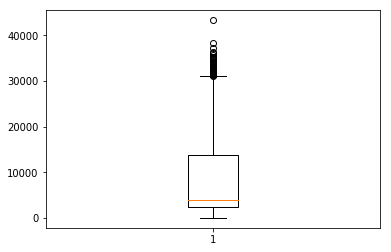

In [40]:
plt.boxplot(train_agg_df['case_count'])

## Now let me extract the date, month and year from the application date field

In [41]:
#train_agg_df.year.unique()

## The loans are influenced by economic factors and also the company offering the loan. 
## I will consider the GDP growth rate of the country 

### Let me include the GDP Growth rate of the country now. I will use the data available from wikipedia and news papers
### As per https://en.wikipedia.org/wiki/List_of_countries_by_real_GDP_growth_rate The GDP growth rate of India for 2016 was 7.11%, for yesr 2017 was 6.62%, for 2018 was 7.30%
### As per RBI forecast available at https://www.rbi.org.in/Scripts/PublicationsView.aspx?id=19334 , the GDP growth rate will be 6.2%
### As per https://economictimes.indiatimes.com/news/economy/indicators/imf-cuts-indias-fy20-gdp-growth-forecast-to-4-8/articleshow/73435183.cms?from=mdr projected GDP growth will be 4.8


### I will add above data to the train and test dataset

In [42]:
def add_gdp_data(row):
    gdp_val = 6.62
    if ( (row['application_date'] > datetime(2017, 4, 1)) and  (row['application_date'] < datetime(2018, 3, 31))):
        gdp_val = 6.62
    elif ( (row['application_date'] > datetime(2018, 4, 1)) and  (row['application_date'] < datetime(2019, 3, 31))):
        gdp_val = 7.30
    elif ( (row['application_date'] > datetime(2019, 4, 1)) and  (row['application_date'] < datetime(2020, 3, 31))):
        gdp_val = 4.8
    elif ( (row['application_date'] > datetime(2020, 4, 1)) and  (row['application_date'] < datetime(2021, 3, 31))):
        gdp_val = 5.5
    
    return gdp_val


## Now let me add the list of holidays to the train and test dataset. As per my understanding all 2nd and 4th Saturdays are holidays. 
## On top of this we may need to consider other public holidays
## I will refer to the holidays in the link "https://www.ltfs.com/content/dam/lnt-financial-services/LTMF_images/AMCholidaylist/Holiday_list_for_LTMFbranches.pdf" and also "https://www.calendarlabs.com/holidays/india/2018" 


In [43]:
from datetime import date 
import holidays 

#ind_holidays = holidays.India() 
#print(ind_holidays)
# Print all the holidays in UnitedKingdom in year 2018 
#for ptr in holidays.India(years = 2021).items(): 
#    print(ptr) 

#Added new year day and also Tamil new year day as Tamilnadu contributes to most of the cases 
holiday_list_2017 = ['2017-01-01', '2017-01-14', '2017-01-26', '2017-03-14', '2017-05-01', '2017-06-26', '2017-08-15', 
                     '2017-08-25', '2017-10-02', '2017-09-30','2017-10-19', '2017-12-25']
## 
holiday_list_2018 = ['2018-01-01','2018-01-14','2018-01-26', '2018-04-14', '2018-05-01', '2018-06-15', '2017-08-15', 
                     '2018-08-22', '2018-09-13', '2018-10-19','2018-10-02', '2018-11-08', '2018-12-25']

holiday_list_2019 = ['2019-01-01', '2019-01-14', '2019-01-26','2019-04-14','2019-05-01', '2019-06-05', '2019-08-15',
                     '2019-09-02', '2019-10-02', '2019-10-08','2019-10-27', '2019-11-10', '2019-12-25']

public_holidays_17_18_19 = holiday_list_2017 + holiday_list_2018 + holiday_list_2019

def is_2nd_4th_sat_or_sunday(rowdate, holidaylist = public_holidays_17_18_19):
    outcome = False
    month_calender = monthcalendar(rowdate.year, rowdate.month)
    second_fourth_saturday = (1,3) if month_calender[0][SATURDAY] else (2,4)
    outcome =  any(rowdate.day == month_calender[i][SATURDAY] for i in second_fourth_saturday)
    #print('======>', rowdate.weekday())
    if (outcome == False):
        outcome = (rowdate.weekday() == 6)
    if (outcome == False):
        outcome = rowdate.strftime('%Y-%m-%d') in holidaylist
    return outcome
        

      
def mark_as_holiday(row, holidaylist = public_holidays_17_18_19):
    outcome = False
    month_calender = monthcalendar(row['application_date'].year, row['application_date'].month)
    second_fourth_saturday = (1,3) if month_calender[0][SATURDAY] else (2,4)
    outcome =  any(row['application_date'].day == month_calender[i][SATURDAY] for i in second_fourth_saturday)
    #print('======>', rowdate.weekday())
    if (outcome == False):
        outcome = (row['application_date'].weekday() == 6)
    if (outcome == False):
        outcome = row['application_date'].strftime('%Y-%m-%d') in holidaylist
        
    if (outcome):
        outcome = 1
    else:
        outcome = 0
    #print(outcome)    
    return outcome

print(is_2nd_4th_sat_or_sunday (datetime.today()))
print(is_2nd_4th_sat_or_sunday (datetime(2020, 1, 11)))
print(is_2nd_4th_sat_or_sunday (datetime(2020, 1, 26)))
print(is_2nd_4th_sat_or_sunday (datetime(2020, 2, 2)))
print(is_2nd_4th_sat_or_sunday (datetime(2019, 1, 1)))
print(is_2nd_4th_sat_or_sunday (datetime(2018, 1, 26)))
print(is_2nd_4th_sat_or_sunday (datetime(2018, 1, 24)))



True
True
True
True
True
True
False


## Customer purchases are influiced by the festival seasions which are driven by the Indian calendar. I will add indian calendar date and month to the dataset.

In [44]:
def add_indian_cal_month(row):
    ind_cal = indian_civil.from_gregorian(row['year'], row['month'], row['day'])
    return ind_cal[1]

def add_indian_cal_date(row):
    ind_cal = indian_civil.from_gregorian(row['year'], row['month'], row['day'])
    return ind_cal[2]

def add_months_elapsed(row):
    print('year:::', )
    months_elapsed = ((row['year'] - 2017) + 1) * row['month']
    months_elapsed


## Let me check if indian general elections had any impact of the loan application numbers
## I will mark the time from 01-Jan-2019 till 18-May-2018 during which all the phases of the elections were completed. Possibly the impact of the budget and company financial year was till March 31st so I will mark last 2 quarters as election phase

In [45]:
def add_election_phase(row):
    election_time = 0
    if (row['application_date'] > datetime(2018, 10, 1) and row['application_date'] < datetime(2019, 3, 31)) :
        election_time = 1
    return election_time


## Feature engineering. Adding all required data such as GDP growth, 
## Indian calendar date and month, holiday, election phase, months elapsed and NSE data

In [46]:
train_agg_df['gdp_growth'] = train_agg_df.apply(add_gdp_data, axis = 1)
train_agg_df['indian_month'] = train_agg_df.apply(add_indian_cal_month, axis = 1)
train_agg_df['indian_date']  = train_agg_df.apply(add_indian_cal_date, axis = 1)
train_agg_df['is_holiday'] = train_agg_df.apply(mark_as_holiday, axis = 1)
train_agg_df['election_phase'] = train_agg_df.apply(add_election_phase, axis = 1)
train_agg_df = pd.merge(train_agg_df, nifty500_df[['application_date','nse500_index']], on=['application_date'])
train_agg_df['months_elapsed'] = ((train_agg_df['year'] - 2017) + 1) * train_agg_df['month']

train_agg_df.head()
print(train_agg_df.indian_month.unique())
print(train_agg_df.indian_date.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30  1  2  3  4
  5  6  7  8  9 10 31]


In [47]:
train_agg_df.head()

,application_date,segment,case_count,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
0,2017-04-01,1,299.0,2017,1,4,5,0,6.62,1,11,0,0,7995.05,4
1,2017-04-01,2,897.0,2017,1,4,5,0,6.62,1,11,0,0,7995.05,4
2,2017-04-02,2,605.0,2017,2,4,6,0,6.62,1,12,1,0,7995.05,4
3,2017-04-03,1,42.0,2017,3,4,0,0,6.62,1,13,0,0,8053.15,4
4,2017-04-03,2,2016.0,2017,3,4,0,0,6.62,1,13,0,0,8053.15,4


In [48]:
## Adding the feature engineering attributes to the test data

In [49]:
x_test = test_df.drop('id', axis = 1)

x_test['year'] = x_test['application_date'].dt.year
x_test['day'] = x_test['application_date'].dt.day
x_test['month'] = x_test['application_date'].dt.month
x_test['day_of_week'] = x_test['application_date'].dt.dayofweek
x_test['quarter'] = pd.PeriodIndex(x_test['application_date'], freq='Q-MAR').strftime('Q%q')
test_encoded_quarter = label_encoder.transform(x_test['quarter'])
x_test['quarter'] = test_encoded_quarter

x_test['gdp_growth'] = x_test.apply(add_gdp_data, axis = 1)
x_test['indian_month'] = x_test.apply(add_indian_cal_month, axis = 1)
x_test['indian_date']  = x_test.apply(add_indian_cal_date, axis = 1)
x_test['is_holiday'] = x_test.apply(mark_as_holiday, axis = 1)
x_test['election_phase'] = x_test.apply(add_election_phase, axis = 1)

x_test = pd.merge(x_test, nifty500_df[['application_date','nse500_index']], on=['application_date'])
x_test['months_elapsed'] = ((x_test['year'] - 2017) + 1) * x_test['month']


x_test.drop('application_date', axis=1, inplace=True)

x_test.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
0,1,2019,6,7,5,1,4.8,4,15,0,0,9657.65,21
1,1,2019,7,7,6,1,4.8,4,16,1,0,9657.65,21
2,1,2019,8,7,0,1,4.8,4,17,0,0,9447.80,21
3,1,2019,9,7,1,1,4.8,4,18,0,0,9455.65,21
4,1,2019,10,7,2,1,4.8,4,19,0,0,9400.10,21


In [50]:
train_model_df = train_agg_df[train_agg_df['application_date'] < datetime(2019, 5, 20) ]
test_model_df = train_agg_df[train_agg_df['application_date'] >= datetime(2019, 5, 20) ]

train_model_seg1_df = train_model_df[train_model_df['segment'] == 1]
train_model_seg2_df = train_model_df[train_model_df['segment'] == 2]

test_model_seg1_df = test_model_df[test_model_df['segment'] == 1]
test_model_seg2_df = test_model_df[test_model_df['segment'] == 2]

print(train_model_df.shape)
print(test_model_df.shape)
train_model_seg1_df.head()

(1538, 15)
(112, 15)


,application_date,segment,case_count,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
0,2017-04-01,1,299.0,2017,1,4,5,0,6.62,1,11,0,0,7995.05,4
3,2017-04-03,1,42.0,2017,3,4,0,0,6.62,1,13,0,0,8053.15,4
5,2017-04-04,1,23.0,2017,4,4,1,0,6.62,1,14,0,0,8053.15,4
7,2017-04-05,1,1530.0,2017,5,4,2,0,6.62,1,15,0,0,8095.10,4
10,2017-04-07,1,1341.0,2017,7,4,4,0,6.62,1,17,0,0,8045.35,4


## Let me plot the time series graph

In [51]:
plot_train = train_model_df.drop(['segment', 'year', 'day', 'month', 'day_of_week', 'nse500_index'], axis = 1)
plot_test = test_model_df.drop(['segment', 'year', 'day', 'month', 'day_of_week', 'nse500_index'], axis = 1)
plot_train.head()

#train_model_df['application_date', 'case_count']

,application_date,case_count,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,months_elapsed
0,2017-04-01,299.0,0,6.62,1,11,0,0,4
1,2017-04-01,897.0,0,6.62,1,11,0,0,4
2,2017-04-02,605.0,0,6.62,1,12,1,0,4
3,2017-04-03,42.0,0,6.62,1,13,0,0,4
4,2017-04-03,2016.0,0,6.62,1,13,0,0,4


In [52]:
plot_test.head()

,application_date,case_count,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,months_elapsed
1538,2019-05-20,3927.0,0,4.8,2,30,0,0,15
1539,2019-05-20,27489.0,0,4.8,2,30,0,0,15
1540,2019-05-21,3175.0,0,4.8,2,31,0,0,15
1541,2019-05-21,29749.0,0,4.8,2,31,0,0,15
1542,2019-05-22,3510.0,0,4.8,3,1,0,0,15


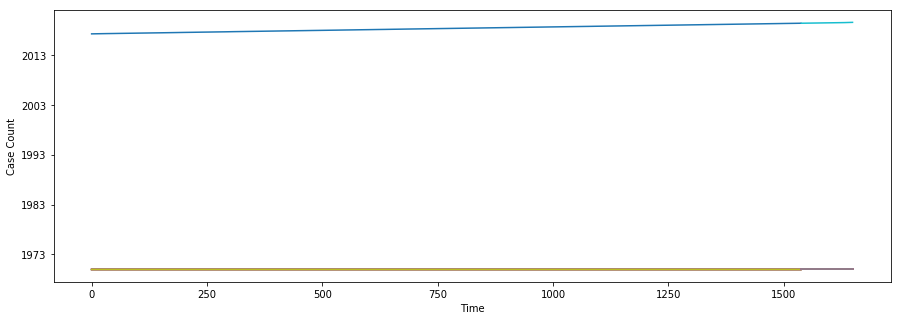

In [53]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Case Count')
plt.plot(plot_train.index,plot_train)
plt.plot(plot_test.index,plot_test)
plt.show()

In [54]:
#Now let me drop the application_date column
train_model_seg1_df.drop('application_date', axis = 1, inplace=True)
train_model_seg2_df.drop('application_date', axis = 1, inplace=True)

test_model_seg1_df.drop('application_date', axis = 1, inplace=True)
test_model_seg2_df.drop('application_date', axis = 1, inplace=True)


## I will create two models one for the segment 1 and the other for the segment 2

In [55]:
# create x and y train
y_train_model_seg1_df = train_model_seg1_df.pop('case_count')
y_train_model_seg2_df = train_model_seg2_df.pop('case_count')

y_test_model_seg1_df = test_model_seg1_df.pop('case_count')
y_test_model_seg2_df = test_model_seg2_df.pop('case_count')



In [56]:
mean_train1 = np.mean(y_train_model_seg1_df)

baseline_predictions1 = np.ones(y_test_model_seg1_df.shape) * mean_train1
# Compute MAE
mae_baseline1 = mean_absolute_error(y_test_model_seg1_df, baseline_predictions1)
print("Baseline MAE is {:.2f}".format(mae_baseline1))

Baseline MAE is 892.96


In [57]:
mean_train2 = np.mean(y_train_model_seg2_df)

baseline_predictions2 = np.ones(y_test_model_seg2_df.shape) * mean_train2
# Compute MAE
mae_baseline2 = mean_absolute_error(y_test_model_seg2_df, baseline_predictions2)
print("Baseline MAE is {:.2f}".format(mae_baseline2))

Baseline MAE is 10247.27


In [58]:
test_model_seg2_df.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
1539,2,2019,20,5,0,0,4.8,2,30,0,0,9671.90,15
1541,2,2019,21,5,1,0,4.8,2,31,0,0,9578.85,15
1543,2,2019,22,5,2,0,4.8,3,1,0,0,9598.20,15
1545,2,2019,23,5,3,0,4.8,3,2,0,0,9552.75,15
1547,2,2019,24,5,4,0,4.8,3,3,0,0,9722.05,15


In [59]:
test_model_seg1_df.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
1538,1,2019,20,5,0,0,4.8,2,30,0,0,9671.90,15
1540,1,2019,21,5,1,0,4.8,2,31,0,0,9578.85,15
1542,1,2019,22,5,2,0,4.8,3,1,0,0,9598.20,15
1544,1,2019,23,5,3,0,4.8,3,2,0,0,9552.75,15
1546,1,2019,24,5,4,0,4.8,3,3,0,0,9722.05,15


In [60]:
train_model_seg1_df.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
0,1,2017,1,4,5,0,6.62,1,11,0,0,7995.05,4
3,1,2017,3,4,0,0,6.62,1,13,0,0,8053.15,4
5,1,2017,4,4,1,0,6.62,1,14,0,0,8053.15,4
7,1,2017,5,4,2,0,6.62,1,15,0,0,8095.10,4
10,1,2017,7,4,4,0,6.62,1,17,0,0,8045.35,4


In [61]:
train_model_seg2_df.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
1,2,2017,1,4,5,0,6.62,1,11,0,0,7995.05,4
2,2,2017,2,4,6,0,6.62,1,12,1,0,7995.05,4
4,2,2017,3,4,0,0,6.62,1,13,0,0,8053.15,4
6,2,2017,4,4,1,0,6.62,1,14,0,0,8053.15,4
8,2,2017,5,4,2,0,6.62,1,15,0,0,8095.10,4


In [62]:
print(y_test_model_seg1_df.shape)
print(y_test_model_seg2_df.shape)

(47,)
(65,)


In [63]:
test_model_seg1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 1538 to 1630
Data columns (total 13 columns):
segment           47 non-null int64
year              47 non-null int64
day               47 non-null int64
month             47 non-null int64
day_of_week       47 non-null int64
quarter           47 non-null int64
gdp_growth        47 non-null float64
indian_month      47 non-null int64
indian_date       47 non-null int64
is_holiday        47 non-null int64
election_phase    47 non-null int64
nse500_index      47 non-null float64
months_elapsed    47 non-null int64
dtypes: float64(2), int64(11)
memory usage: 5.1 KB


## Train segment 1 model

In [64]:
xgb1 = XGBRegressor(learning_rate=.01,  min_child_weight=2, n_estimators=10000, gamma=4, subsample=0.75, colsample_bytree=1, max_depth=4)

xgb1.fit(train_model_seg1_df, y_train_model_seg1_df, eval_set=[(train_model_seg1_df, y_train_model_seg1_df), (test_model_seg1_df, y_test_model_seg1_df)],  early_stopping_rounds=100, eval_metric='mae', verbose = True)

[23:39:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2657.39	validation_1-mae:3186.63
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:2631.58	validation_1-mae:3158.9
[2]	validation_0-mae:2605.91	validation_1-mae:3134.54
[3]	validation_0-mae:2582.16	validation_1-mae:3106.96
[4]	validation_0-mae:2557.92	validation_1-mae:3085.99
[5]	validation_0-mae:2534.73	validation_1-mae:3059.34
[6]	validation_0-mae:2510.69	validation_1-mae:3037.1
[7]	validation_0-mae:2487.39	validation_1-mae:3012.97
[8]	validation_0-mae:2464.78	validation_1-mae:2992.91
[9]	validation_0-mae:2441.85	validation_1-mae:2967.44
[10]	validation_0-mae:2419.82	validation_1-mae:2943.4
[11]	validation_0-mae:2397.35	validation_1-mae:2922.15
[12]	validation_0-mae:2375.81	v

[144]	validation_0-mae:879.723	validation_1-mae:1183.91
[145]	validation_0-mae:875.052	validation_1-mae:1175.95
[146]	validation_0-mae:870.494	validation_1-mae:1170.22
[147]	validation_0-mae:865.749	validation_1-mae:1163.86
[148]	validation_0-mae:860.98	validation_1-mae:1156.22
[149]	validation_0-mae:856.424	validation_1-mae:1148.54
[150]	validation_0-mae:851.596	validation_1-mae:1141.55
[151]	validation_0-mae:846.966	validation_1-mae:1134.35
[152]	validation_0-mae:842.79	validation_1-mae:1128.66
[153]	validation_0-mae:838.627	validation_1-mae:1122.16
[154]	validation_0-mae:834.571	validation_1-mae:1116.72
[155]	validation_0-mae:830.726	validation_1-mae:1112.24
[156]	validation_0-mae:826.487	validation_1-mae:1105.54
[157]	validation_0-mae:822.861	validation_1-mae:1098.93
[158]	validation_0-mae:819.405	validation_1-mae:1092.85
[159]	validation_0-mae:815.598	validation_1-mae:1087.32
[160]	validation_0-mae:811.567	validation_1-mae:1083
[161]	validation_0-mae:807.855	validation_1-mae:1077.

[291]	validation_0-mae:589.27	validation_1-mae:669.856
[292]	validation_0-mae:588.509	validation_1-mae:668.274
[293]	validation_0-mae:588.021	validation_1-mae:666.188
[294]	validation_0-mae:587.439	validation_1-mae:665.333
[295]	validation_0-mae:586.76	validation_1-mae:663.592
[296]	validation_0-mae:586.009	validation_1-mae:660.329
[297]	validation_0-mae:585.466	validation_1-mae:658.86
[298]	validation_0-mae:584.907	validation_1-mae:656.916
[299]	validation_0-mae:584.318	validation_1-mae:656.288
[300]	validation_0-mae:583.397	validation_1-mae:652.382
[301]	validation_0-mae:582.745	validation_1-mae:651.161
[302]	validation_0-mae:582.012	validation_1-mae:650.293
[303]	validation_0-mae:581.321	validation_1-mae:650.106
[304]	validation_0-mae:580.691	validation_1-mae:648.498
[305]	validation_0-mae:580.17	validation_1-mae:647.236
[306]	validation_0-mae:579.434	validation_1-mae:646.32
[307]	validation_0-mae:579.025	validation_1-mae:645.456
[308]	validation_0-mae:578.635	validation_1-mae:644.4

[439]	validation_0-mae:513.457	validation_1-mae:510.136
[440]	validation_0-mae:512.847	validation_1-mae:509.884
[441]	validation_0-mae:512.511	validation_1-mae:509.369
[442]	validation_0-mae:512.185	validation_1-mae:508.727
[443]	validation_0-mae:511.862	validation_1-mae:508.793
[444]	validation_0-mae:511.518	validation_1-mae:508.945
[445]	validation_0-mae:511.089	validation_1-mae:508.659
[446]	validation_0-mae:510.525	validation_1-mae:507.979
[447]	validation_0-mae:510.179	validation_1-mae:507.51
[448]	validation_0-mae:509.753	validation_1-mae:506.296
[449]	validation_0-mae:509.167	validation_1-mae:505.712
[450]	validation_0-mae:508.727	validation_1-mae:505.134
[451]	validation_0-mae:508.19	validation_1-mae:504.034
[452]	validation_0-mae:507.47	validation_1-mae:503.622
[453]	validation_0-mae:507.028	validation_1-mae:503.267
[454]	validation_0-mae:506.453	validation_1-mae:503.186
[455]	validation_0-mae:505.906	validation_1-mae:502.969
[456]	validation_0-mae:505.374	validation_1-mae:500

[586]	validation_0-mae:453.704	validation_1-mae:455.706
[587]	validation_0-mae:453.335	validation_1-mae:455.49
[588]	validation_0-mae:453.003	validation_1-mae:455.633
[589]	validation_0-mae:452.66	validation_1-mae:455.576
[590]	validation_0-mae:452.203	validation_1-mae:455.579
[591]	validation_0-mae:451.758	validation_1-mae:455.553
[592]	validation_0-mae:451.339	validation_1-mae:455.103
[593]	validation_0-mae:451.089	validation_1-mae:454.775
[594]	validation_0-mae:450.781	validation_1-mae:454.033
[595]	validation_0-mae:450.201	validation_1-mae:454.293
[596]	validation_0-mae:449.922	validation_1-mae:454.123
[597]	validation_0-mae:449.696	validation_1-mae:454.43
[598]	validation_0-mae:448.882	validation_1-mae:453.718
[599]	validation_0-mae:448.614	validation_1-mae:453.712
[600]	validation_0-mae:448.178	validation_1-mae:453.163
[601]	validation_0-mae:447.697	validation_1-mae:453.032
[602]	validation_0-mae:447.552	validation_1-mae:453.013
[603]	validation_0-mae:447.258	validation_1-mae:452

[733]	validation_0-mae:408.24	validation_1-mae:445.483
[734]	validation_0-mae:408.084	validation_1-mae:445.267
[735]	validation_0-mae:407.734	validation_1-mae:445.206
[736]	validation_0-mae:407.34	validation_1-mae:447.141
[737]	validation_0-mae:407.133	validation_1-mae:446.996
[738]	validation_0-mae:406.814	validation_1-mae:447.091
[739]	validation_0-mae:406.557	validation_1-mae:447.272
[740]	validation_0-mae:406.332	validation_1-mae:447.616
[741]	validation_0-mae:406.166	validation_1-mae:447.767
[742]	validation_0-mae:405.966	validation_1-mae:447.274
[743]	validation_0-mae:405.7	validation_1-mae:446.989
[744]	validation_0-mae:405.395	validation_1-mae:444.829
[745]	validation_0-mae:405.2	validation_1-mae:444.743
[746]	validation_0-mae:404.888	validation_1-mae:444.931
[747]	validation_0-mae:404.495	validation_1-mae:443.605
[748]	validation_0-mae:404.343	validation_1-mae:443.83
[749]	validation_0-mae:403.955	validation_1-mae:443.758
[750]	validation_0-mae:403.634	validation_1-mae:442.585

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=4,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.75, verbosity=1)

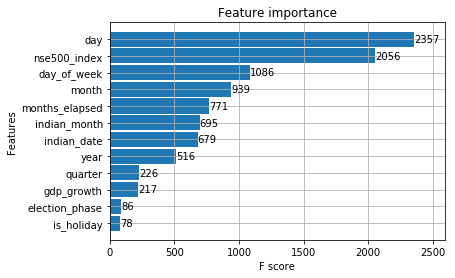

In [65]:
_ = plot_importance(xgb1, height=0.9)

## Let me train the segment 2 model now

In [66]:
xgb2 = XGBRegressor(learning_rate=.005, booster='gbtree',  min_child_weight=1, n_estimators=20000, gamma=5, subsample=0.8, colsample_bytree=1, max_depth=4)
#xgb2 = XGBRFRegressor(n_estimators=10000, gamma=10, max_depth=5)
xgb2.fit(train_model_seg2_df, y_train_model_seg2_df, eval_set=[(train_model_seg2_df, y_train_model_seg2_df), (test_model_seg2_df, y_test_model_seg2_df)],  early_stopping_rounds=100, eval_metric='mae', verbose = True)

[23:39:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:14821.6	validation_1-mae:17163.1
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:14749.2	validation_1-mae:17076.9
[2]	validation_0-mae:14675.9	validation_1-mae:16994.4
[3]	validation_0-mae:14604.2	validation_1-mae:16910.7
[4]	validation_0-mae:14533.5	validation_1-mae:16825
[5]	validation_0-mae:14461.8	validation_1-mae:16745.2
[6]	validation_0-mae:14389.6	validation_1-mae:16660.8
[7]	validation_0-mae:14318.7	validation_1-mae:16582.8
[8]	validation_0-mae:14248.4	validation_1-mae:16498.5
[9]	validation_0-mae:14178.1	validation_1-mae:16416.2
[10]	validation_0-mae:14107.6	validation_1-mae:16336.1
[11]	validation_0-mae:14038	validation_1-mae:16257
[12]	validation_0-mae:13969.6	vali

[144]	validation_0-mae:7424.78	validation_1-mae:8465.64
[145]	validation_0-mae:7390.71	validation_1-mae:8419.91
[146]	validation_0-mae:7356.49	validation_1-mae:8378.37
[147]	validation_0-mae:7324.19	validation_1-mae:8336.52
[148]	validation_0-mae:7290.23	validation_1-mae:8298.28
[149]	validation_0-mae:7256.66	validation_1-mae:8258.02
[150]	validation_0-mae:7223.07	validation_1-mae:8212.8
[151]	validation_0-mae:7190.17	validation_1-mae:8173.73
[152]	validation_0-mae:7158.01	validation_1-mae:8130.46
[153]	validation_0-mae:7125.72	validation_1-mae:8089.99
[154]	validation_0-mae:7093.81	validation_1-mae:8049.11
[155]	validation_0-mae:7062.08	validation_1-mae:8010.25
[156]	validation_0-mae:7030.87	validation_1-mae:7971.51
[157]	validation_0-mae:7000.13	validation_1-mae:7932.01
[158]	validation_0-mae:6969.16	validation_1-mae:7893.95
[159]	validation_0-mae:6937.18	validation_1-mae:7854.06
[160]	validation_0-mae:6905.68	validation_1-mae:7814.17
[161]	validation_0-mae:6874.47	validation_1-mae:7

[291]	validation_0-mae:4035.76	validation_1-mae:4624.97
[292]	validation_0-mae:4020.85	validation_1-mae:4608.38
[293]	validation_0-mae:4006.87	validation_1-mae:4592.65
[294]	validation_0-mae:3992.95	validation_1-mae:4584.08
[295]	validation_0-mae:3978.9	validation_1-mae:4567.96
[296]	validation_0-mae:3964.82	validation_1-mae:4551.28
[297]	validation_0-mae:3951.06	validation_1-mae:4535.96
[298]	validation_0-mae:3937.93	validation_1-mae:4526.6
[299]	validation_0-mae:3924.09	validation_1-mae:4511.91
[300]	validation_0-mae:3910.5	validation_1-mae:4497.9
[301]	validation_0-mae:3897.49	validation_1-mae:4489.47
[302]	validation_0-mae:3884.83	validation_1-mae:4475.86
[303]	validation_0-mae:3871.54	validation_1-mae:4467.48
[304]	validation_0-mae:3857.35	validation_1-mae:4460.01
[305]	validation_0-mae:3844.46	validation_1-mae:4451.19
[306]	validation_0-mae:3831.29	validation_1-mae:4436.7
[307]	validation_0-mae:3819.28	validation_1-mae:4422.46
[308]	validation_0-mae:3806.34	validation_1-mae:4414.

[438]	validation_0-mae:2678.22	validation_1-mae:3311.27
[439]	validation_0-mae:2672.45	validation_1-mae:3304.84
[440]	validation_0-mae:2666.97	validation_1-mae:3298.73
[441]	validation_0-mae:2661.8	validation_1-mae:3294.27
[442]	validation_0-mae:2656.18	validation_1-mae:3288.82
[443]	validation_0-mae:2650.89	validation_1-mae:3286.41
[444]	validation_0-mae:2645.68	validation_1-mae:3284.48
[445]	validation_0-mae:2640.43	validation_1-mae:3276.48
[446]	validation_0-mae:2635.11	validation_1-mae:3272.56
[447]	validation_0-mae:2629.62	validation_1-mae:3263.11
[448]	validation_0-mae:2624.35	validation_1-mae:3258.92
[449]	validation_0-mae:2619.58	validation_1-mae:3255.64
[450]	validation_0-mae:2614.06	validation_1-mae:3253.83
[451]	validation_0-mae:2608.64	validation_1-mae:3247.03
[452]	validation_0-mae:2603.34	validation_1-mae:3242.79
[453]	validation_0-mae:2598.36	validation_1-mae:3238.53
[454]	validation_0-mae:2593.43	validation_1-mae:3233
[455]	validation_0-mae:2588.86	validation_1-mae:3231

[585]	validation_0-mae:2135.64	validation_1-mae:2811.22
[586]	validation_0-mae:2133.01	validation_1-mae:2810.95
[587]	validation_0-mae:2130.66	validation_1-mae:2809.06
[588]	validation_0-mae:2128.03	validation_1-mae:2808.56
[589]	validation_0-mae:2125.51	validation_1-mae:2808.26
[590]	validation_0-mae:2122.95	validation_1-mae:2807.26
[591]	validation_0-mae:2120.29	validation_1-mae:2806.5
[592]	validation_0-mae:2117.95	validation_1-mae:2805.06
[593]	validation_0-mae:2115.6	validation_1-mae:2803.02
[594]	validation_0-mae:2113.28	validation_1-mae:2800.93
[595]	validation_0-mae:2111.46	validation_1-mae:2799.1
[596]	validation_0-mae:2109.01	validation_1-mae:2794.45
[597]	validation_0-mae:2107.04	validation_1-mae:2792.58
[598]	validation_0-mae:2104.97	validation_1-mae:2789.29
[599]	validation_0-mae:2102.52	validation_1-mae:2787.7
[600]	validation_0-mae:2100.09	validation_1-mae:2784.16
[601]	validation_0-mae:2097.79	validation_1-mae:2782.05
[602]	validation_0-mae:2095.14	validation_1-mae:2777

[733]	validation_0-mae:1863.59	validation_1-mae:2577.63
[734]	validation_0-mae:1862.5	validation_1-mae:2576.76
[735]	validation_0-mae:1861	validation_1-mae:2573.87
[736]	validation_0-mae:1859.92	validation_1-mae:2573.63
[737]	validation_0-mae:1858.37	validation_1-mae:2573.43
[738]	validation_0-mae:1856.57	validation_1-mae:2573.21
[739]	validation_0-mae:1855.23	validation_1-mae:2574.03
[740]	validation_0-mae:1853.6	validation_1-mae:2574.42
[741]	validation_0-mae:1852.18	validation_1-mae:2574.46
[742]	validation_0-mae:1851.21	validation_1-mae:2573.42
[743]	validation_0-mae:1849.8	validation_1-mae:2572.76
[744]	validation_0-mae:1848.27	validation_1-mae:2572.14
[745]	validation_0-mae:1847.17	validation_1-mae:2571.7
[746]	validation_0-mae:1845.62	validation_1-mae:2570.9
[747]	validation_0-mae:1844.36	validation_1-mae:2571.48
[748]	validation_0-mae:1843.14	validation_1-mae:2570.88
[749]	validation_0-mae:1841.97	validation_1-mae:2568.29
[750]	validation_0-mae:1840.94	validation_1-mae:2568
[75

[881]	validation_0-mae:1701.38	validation_1-mae:2474.82
[882]	validation_0-mae:1700.47	validation_1-mae:2474.06
[883]	validation_0-mae:1699.46	validation_1-mae:2471.28
[884]	validation_0-mae:1698.44	validation_1-mae:2473.21
[885]	validation_0-mae:1697.88	validation_1-mae:2474.11
[886]	validation_0-mae:1697.04	validation_1-mae:2474.26
[887]	validation_0-mae:1696.19	validation_1-mae:2473.66
[888]	validation_0-mae:1695.35	validation_1-mae:2472.36
[889]	validation_0-mae:1694.36	validation_1-mae:2472.51
[890]	validation_0-mae:1693.46	validation_1-mae:2472.49
[891]	validation_0-mae:1692.7	validation_1-mae:2472.34
[892]	validation_0-mae:1692.07	validation_1-mae:2470.88
[893]	validation_0-mae:1691.31	validation_1-mae:2470.28
[894]	validation_0-mae:1690.63	validation_1-mae:2469.87
[895]	validation_0-mae:1689.6	validation_1-mae:2468.6
[896]	validation_0-mae:1688.63	validation_1-mae:2468.7
[897]	validation_0-mae:1687.64	validation_1-mae:2470.51
[898]	validation_0-mae:1686.77	validation_1-mae:2470

[1028]	validation_0-mae:1584.19	validation_1-mae:2403.58
[1029]	validation_0-mae:1583.65	validation_1-mae:2403.72
[1030]	validation_0-mae:1582.96	validation_1-mae:2403.84
[1031]	validation_0-mae:1582.29	validation_1-mae:2403.07
[1032]	validation_0-mae:1581.4	validation_1-mae:2402.54
[1033]	validation_0-mae:1580.9	validation_1-mae:2402.09
[1034]	validation_0-mae:1580	validation_1-mae:2401.61
[1035]	validation_0-mae:1579.14	validation_1-mae:2400.52
[1036]	validation_0-mae:1578.32	validation_1-mae:2401.04
[1037]	validation_0-mae:1577.62	validation_1-mae:2399.85
[1038]	validation_0-mae:1576.87	validation_1-mae:2399.46
[1039]	validation_0-mae:1576.17	validation_1-mae:2398.65
[1040]	validation_0-mae:1575.49	validation_1-mae:2397.95
[1041]	validation_0-mae:1574.83	validation_1-mae:2396.08
[1042]	validation_0-mae:1574.25	validation_1-mae:2395.17
[1043]	validation_0-mae:1573.59	validation_1-mae:2395.24
[1044]	validation_0-mae:1572.97	validation_1-mae:2393.99
[1045]	validation_0-mae:1572.38	vali

[1173]	validation_0-mae:1491.73	validation_1-mae:2343.87
[1174]	validation_0-mae:1491.22	validation_1-mae:2343.39
[1175]	validation_0-mae:1490.73	validation_1-mae:2343.23
[1176]	validation_0-mae:1490.22	validation_1-mae:2343.04
[1177]	validation_0-mae:1489.75	validation_1-mae:2341.72
[1178]	validation_0-mae:1489.27	validation_1-mae:2339.65
[1179]	validation_0-mae:1488.66	validation_1-mae:2340.32
[1180]	validation_0-mae:1488.21	validation_1-mae:2340.16
[1181]	validation_0-mae:1487.61	validation_1-mae:2341.65
[1182]	validation_0-mae:1487.16	validation_1-mae:2340.9
[1183]	validation_0-mae:1486.54	validation_1-mae:2339.77
[1184]	validation_0-mae:1485.48	validation_1-mae:2338.67
[1185]	validation_0-mae:1485.12	validation_1-mae:2338.1
[1186]	validation_0-mae:1484.52	validation_1-mae:2338.29
[1187]	validation_0-mae:1483.76	validation_1-mae:2338.8
[1188]	validation_0-mae:1483.08	validation_1-mae:2337.5
[1189]	validation_0-mae:1482.67	validation_1-mae:2337.18
[1190]	validation_0-mae:1482.07	val

[1318]	validation_0-mae:1416.46	validation_1-mae:2297.74
[1319]	validation_0-mae:1416.17	validation_1-mae:2296.96
[1320]	validation_0-mae:1415.69	validation_1-mae:2296.77
[1321]	validation_0-mae:1415.12	validation_1-mae:2297.2
[1322]	validation_0-mae:1414.74	validation_1-mae:2295.37
[1323]	validation_0-mae:1414.52	validation_1-mae:2295.09
[1324]	validation_0-mae:1413.99	validation_1-mae:2293.9
[1325]	validation_0-mae:1413.5	validation_1-mae:2293.21
[1326]	validation_0-mae:1412.96	validation_1-mae:2292.8
[1327]	validation_0-mae:1412.1	validation_1-mae:2292.37
[1328]	validation_0-mae:1411.46	validation_1-mae:2292.29
[1329]	validation_0-mae:1411.01	validation_1-mae:2290.24
[1330]	validation_0-mae:1410.62	validation_1-mae:2289.91
[1331]	validation_0-mae:1410.08	validation_1-mae:2288.49
[1332]	validation_0-mae:1409.4	validation_1-mae:2288.31
[1333]	validation_0-mae:1408.9	validation_1-mae:2288.58
[1334]	validation_0-mae:1408.61	validation_1-mae:2288.4
[1335]	validation_0-mae:1408.06	validat

[1463]	validation_0-mae:1347.52	validation_1-mae:2242.01
[1464]	validation_0-mae:1347.19	validation_1-mae:2240.48
[1465]	validation_0-mae:1346.76	validation_1-mae:2239.78
[1466]	validation_0-mae:1346.1	validation_1-mae:2240.27
[1467]	validation_0-mae:1345.58	validation_1-mae:2240.31
[1468]	validation_0-mae:1345.01	validation_1-mae:2241.02
[1469]	validation_0-mae:1344.49	validation_1-mae:2240.24
[1470]	validation_0-mae:1343.89	validation_1-mae:2240.23
[1471]	validation_0-mae:1343.61	validation_1-mae:2239.64
[1472]	validation_0-mae:1342.98	validation_1-mae:2239.76
[1473]	validation_0-mae:1342.47	validation_1-mae:2239.11
[1474]	validation_0-mae:1342.39	validation_1-mae:2238.46
[1475]	validation_0-mae:1341.99	validation_1-mae:2238.89
[1476]	validation_0-mae:1341.52	validation_1-mae:2237.88
[1477]	validation_0-mae:1340.93	validation_1-mae:2237.65
[1478]	validation_0-mae:1340.62	validation_1-mae:2237.63
[1479]	validation_0-mae:1340.41	validation_1-mae:2236.92
[1480]	validation_0-mae:1339.94	

[1608]	validation_0-mae:1285.93	validation_1-mae:2212.43
[1609]	validation_0-mae:1285.51	validation_1-mae:2211.65
[1610]	validation_0-mae:1285.28	validation_1-mae:2210.98
[1611]	validation_0-mae:1284.73	validation_1-mae:2210.2
[1612]	validation_0-mae:1284.52	validation_1-mae:2209.59
[1613]	validation_0-mae:1284.19	validation_1-mae:2208.55
[1614]	validation_0-mae:1283.94	validation_1-mae:2207.76
[1615]	validation_0-mae:1283.61	validation_1-mae:2207.34
[1616]	validation_0-mae:1283.04	validation_1-mae:2207.15
[1617]	validation_0-mae:1282.77	validation_1-mae:2206.46
[1618]	validation_0-mae:1282.55	validation_1-mae:2206.09
[1619]	validation_0-mae:1281.89	validation_1-mae:2206.09
[1620]	validation_0-mae:1281.2	validation_1-mae:2205.59
[1621]	validation_0-mae:1280.9	validation_1-mae:2205.55
[1622]	validation_0-mae:1280.55	validation_1-mae:2206.66
[1623]	validation_0-mae:1279.96	validation_1-mae:2207.68
[1624]	validation_0-mae:1279.8	validation_1-mae:2207.61
[1625]	validation_0-mae:1279.51	val

[1753]	validation_0-mae:1231.11	validation_1-mae:2174.73
[1754]	validation_0-mae:1230.7	validation_1-mae:2175.09
[1755]	validation_0-mae:1230.41	validation_1-mae:2174.77
[1756]	validation_0-mae:1230.24	validation_1-mae:2174.79
[1757]	validation_0-mae:1229.94	validation_1-mae:2174.66
[1758]	validation_0-mae:1229.7	validation_1-mae:2175.03
[1759]	validation_0-mae:1229.5	validation_1-mae:2175.03
[1760]	validation_0-mae:1229.06	validation_1-mae:2175.03
[1761]	validation_0-mae:1228.67	validation_1-mae:2174.59
[1762]	validation_0-mae:1228.4	validation_1-mae:2174.17
[1763]	validation_0-mae:1228.03	validation_1-mae:2173.88
[1764]	validation_0-mae:1227.69	validation_1-mae:2173.88
[1765]	validation_0-mae:1227.07	validation_1-mae:2174.37
[1766]	validation_0-mae:1226.69	validation_1-mae:2174.36
[1767]	validation_0-mae:1226.29	validation_1-mae:2174.01
[1768]	validation_0-mae:1225.9	validation_1-mae:2174.44
[1769]	validation_0-mae:1225.12	validation_1-mae:2174.17
[1770]	validation_0-mae:1224.73	vali

[1898]	validation_0-mae:1181.24	validation_1-mae:2164.7
[1899]	validation_0-mae:1181.03	validation_1-mae:2164.89
[1900]	validation_0-mae:1180.75	validation_1-mae:2163.4
[1901]	validation_0-mae:1180.38	validation_1-mae:2163.5
[1902]	validation_0-mae:1179.83	validation_1-mae:2161.98
[1903]	validation_0-mae:1179.46	validation_1-mae:2162.8
[1904]	validation_0-mae:1179.13	validation_1-mae:2162.72
[1905]	validation_0-mae:1178.84	validation_1-mae:2162.45
[1906]	validation_0-mae:1178.51	validation_1-mae:2161.78
[1907]	validation_0-mae:1178.18	validation_1-mae:2162.15
[1908]	validation_0-mae:1177.85	validation_1-mae:2162.17
[1909]	validation_0-mae:1177.41	validation_1-mae:2162.03
[1910]	validation_0-mae:1176.99	validation_1-mae:2161.4
[1911]	validation_0-mae:1176.75	validation_1-mae:2161.53
[1912]	validation_0-mae:1176.48	validation_1-mae:2161.16
[1913]	validation_0-mae:1176.38	validation_1-mae:2160.9
[1914]	validation_0-mae:1176.13	validation_1-mae:2160.75
[1915]	validation_0-mae:1175.74	valid

[2043]	validation_0-mae:1137.36	validation_1-mae:2144.11
[2044]	validation_0-mae:1137.01	validation_1-mae:2144.24
[2045]	validation_0-mae:1136.7	validation_1-mae:2143.98
[2046]	validation_0-mae:1136.49	validation_1-mae:2143.98
[2047]	validation_0-mae:1136.11	validation_1-mae:2144.23
[2048]	validation_0-mae:1135.81	validation_1-mae:2144.82
[2049]	validation_0-mae:1135.74	validation_1-mae:2144.48
[2050]	validation_0-mae:1135.3	validation_1-mae:2143.94
[2051]	validation_0-mae:1135.04	validation_1-mae:2143.14
[2052]	validation_0-mae:1134.77	validation_1-mae:2142.55
[2053]	validation_0-mae:1134.48	validation_1-mae:2142.87
[2054]	validation_0-mae:1134.16	validation_1-mae:2143.08
[2055]	validation_0-mae:1133.83	validation_1-mae:2142.77
[2056]	validation_0-mae:1133.5	validation_1-mae:2143.25
[2057]	validation_0-mae:1133.2	validation_1-mae:2143.16
[2058]	validation_0-mae:1132.93	validation_1-mae:2143.3
[2059]	validation_0-mae:1132.76	validation_1-mae:2143.09
[2060]	validation_0-mae:1132.5	valid

[2188]	validation_0-mae:1095.87	validation_1-mae:2124.77
[2189]	validation_0-mae:1095.53	validation_1-mae:2125
[2190]	validation_0-mae:1095.31	validation_1-mae:2124.22
[2191]	validation_0-mae:1095.07	validation_1-mae:2124.35
[2192]	validation_0-mae:1094.65	validation_1-mae:2124.64
[2193]	validation_0-mae:1094.23	validation_1-mae:2124.12
[2194]	validation_0-mae:1093.69	validation_1-mae:2124.07
[2195]	validation_0-mae:1093.6	validation_1-mae:2123.76
[2196]	validation_0-mae:1093.33	validation_1-mae:2124.15
[2197]	validation_0-mae:1093.1	validation_1-mae:2124.39
[2198]	validation_0-mae:1092.88	validation_1-mae:2125.22
[2199]	validation_0-mae:1092.75	validation_1-mae:2125.44
[2200]	validation_0-mae:1092.43	validation_1-mae:2125.55
[2201]	validation_0-mae:1092.07	validation_1-mae:2125.51
[2202]	validation_0-mae:1091.88	validation_1-mae:2125.31
[2203]	validation_0-mae:1091.76	validation_1-mae:2125.64
[2204]	validation_0-mae:1091.52	validation_1-mae:2125.49
[2205]	validation_0-mae:1091.2	valid

[2333]	validation_0-mae:1058.77	validation_1-mae:2119.44
[2334]	validation_0-mae:1058.47	validation_1-mae:2119.84
[2335]	validation_0-mae:1058.2	validation_1-mae:2119.84
[2336]	validation_0-mae:1057.96	validation_1-mae:2119.93
[2337]	validation_0-mae:1057.85	validation_1-mae:2120.11
[2338]	validation_0-mae:1057.61	validation_1-mae:2119.86
[2339]	validation_0-mae:1057.5	validation_1-mae:2119.51
[2340]	validation_0-mae:1057.13	validation_1-mae:2119.04
[2341]	validation_0-mae:1057	validation_1-mae:2118.87
[2342]	validation_0-mae:1056.69	validation_1-mae:2118.48
[2343]	validation_0-mae:1056.37	validation_1-mae:2118.53
[2344]	validation_0-mae:1056.11	validation_1-mae:2118.71
[2345]	validation_0-mae:1055.77	validation_1-mae:2118.74
[2346]	validation_0-mae:1055.71	validation_1-mae:2118.72
[2347]	validation_0-mae:1055.45	validation_1-mae:2118.43
[2348]	validation_0-mae:1055.3	validation_1-mae:2118.42
[2349]	validation_0-mae:1054.88	validation_1-mae:2119.04
[2350]	validation_0-mae:1054.6	valida

[2478]	validation_0-mae:1024.01	validation_1-mae:2116.72
[2479]	validation_0-mae:1023.77	validation_1-mae:2116.05
[2480]	validation_0-mae:1023.67	validation_1-mae:2115.92
[2481]	validation_0-mae:1023.36	validation_1-mae:2115.87
[2482]	validation_0-mae:1023.21	validation_1-mae:2115.85
[2483]	validation_0-mae:1022.87	validation_1-mae:2115.92
[2484]	validation_0-mae:1022.53	validation_1-mae:2115.22
[2485]	validation_0-mae:1022.32	validation_1-mae:2115.8
[2486]	validation_0-mae:1021.98	validation_1-mae:2115.5
[2487]	validation_0-mae:1021.78	validation_1-mae:2115.64
[2488]	validation_0-mae:1021.54	validation_1-mae:2115.35
[2489]	validation_0-mae:1021.22	validation_1-mae:2114.86
[2490]	validation_0-mae:1021.05	validation_1-mae:2115
[2491]	validation_0-mae:1020.91	validation_1-mae:2114.52
[2492]	validation_0-mae:1020.67	validation_1-mae:2114.69
[2493]	validation_0-mae:1020.41	validation_1-mae:2114.62
[2494]	validation_0-mae:1020.12	validation_1-mae:2114.8
[2495]	validation_0-mae:1019.86	valid

[2623]	validation_0-mae:992.141	validation_1-mae:2103.23
[2624]	validation_0-mae:991.871	validation_1-mae:2103.08
[2625]	validation_0-mae:991.645	validation_1-mae:2102.92
[2626]	validation_0-mae:991.378	validation_1-mae:2103.35
[2627]	validation_0-mae:991.075	validation_1-mae:2103.28
[2628]	validation_0-mae:990.846	validation_1-mae:2103.3
[2629]	validation_0-mae:990.733	validation_1-mae:2103.02
[2630]	validation_0-mae:990.561	validation_1-mae:2102.95
[2631]	validation_0-mae:990.253	validation_1-mae:2102.88
[2632]	validation_0-mae:990.065	validation_1-mae:2103.25
[2633]	validation_0-mae:989.872	validation_1-mae:2103.35
[2634]	validation_0-mae:989.502	validation_1-mae:2103.43
[2635]	validation_0-mae:989.283	validation_1-mae:2103.26
[2636]	validation_0-mae:989.157	validation_1-mae:2103.24
[2637]	validation_0-mae:988.82	validation_1-mae:2103.01
[2638]	validation_0-mae:988.516	validation_1-mae:2103.02
[2639]	validation_0-mae:988.421	validation_1-mae:2103.12
[2640]	validation_0-mae:988.229	v

[2768]	validation_0-mae:962.193	validation_1-mae:2099.54
[2769]	validation_0-mae:962.027	validation_1-mae:2099.27
[2770]	validation_0-mae:961.959	validation_1-mae:2099.33
[2771]	validation_0-mae:961.62	validation_1-mae:2099.39
[2772]	validation_0-mae:961.511	validation_1-mae:2098.95
[2773]	validation_0-mae:961.327	validation_1-mae:2098.87
[2774]	validation_0-mae:961.217	validation_1-mae:2099
[2775]	validation_0-mae:961.162	validation_1-mae:2098.96
[2776]	validation_0-mae:960.9	validation_1-mae:2098.99
[2777]	validation_0-mae:960.8	validation_1-mae:2098.8
[2778]	validation_0-mae:960.521	validation_1-mae:2098.56
[2779]	validation_0-mae:960.32	validation_1-mae:2098.53
[2780]	validation_0-mae:960.154	validation_1-mae:2098.56
[2781]	validation_0-mae:959.997	validation_1-mae:2098.76
[2782]	validation_0-mae:959.76	validation_1-mae:2098.3
[2783]	validation_0-mae:959.598	validation_1-mae:2098.79
[2784]	validation_0-mae:959.327	validation_1-mae:2098.84
[2785]	validation_0-mae:959.061	validation_

[2913]	validation_0-mae:934.043	validation_1-mae:2089.13
[2914]	validation_0-mae:933.871	validation_1-mae:2089.07
[2915]	validation_0-mae:933.631	validation_1-mae:2089.1
[2916]	validation_0-mae:933.375	validation_1-mae:2088.88
[2917]	validation_0-mae:933.076	validation_1-mae:2088.69
[2918]	validation_0-mae:932.85	validation_1-mae:2088.58
[2919]	validation_0-mae:932.674	validation_1-mae:2088.59
[2920]	validation_0-mae:932.454	validation_1-mae:2088.54
[2921]	validation_0-mae:932.32	validation_1-mae:2088.82
[2922]	validation_0-mae:932.069	validation_1-mae:2088.55
[2923]	validation_0-mae:931.898	validation_1-mae:2088.83
[2924]	validation_0-mae:931.798	validation_1-mae:2088.51
[2925]	validation_0-mae:931.733	validation_1-mae:2088.56
[2926]	validation_0-mae:931.588	validation_1-mae:2088.58
[2927]	validation_0-mae:931.326	validation_1-mae:2088.4
[2928]	validation_0-mae:931.08	validation_1-mae:2088.67
[2929]	validation_0-mae:930.974	validation_1-mae:2088.79
[2930]	validation_0-mae:930.731	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=5,
       importance_type='gain', learning_rate=0.005, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=20000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

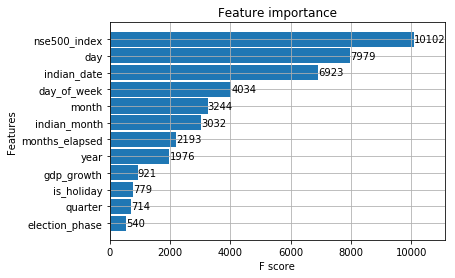

In [67]:
_ = plot_importance(xgb2, height=0.9)

In [68]:
test_df.head()

,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [69]:
x_test_seg1 = x_test[x_test['segment']==1]
x_test_seg2 = x_test[x_test['segment']==2]

x_test_seg1.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed
0,1,2019,6,7,5,1,4.8,4,15,0,0,9657.65,21
1,1,2019,7,7,6,1,4.8,4,16,1,0,9657.65,21
2,1,2019,8,7,0,1,4.8,4,17,0,0,9447.80,21
3,1,2019,9,7,1,1,4.8,4,18,0,0,9455.65,21
4,1,2019,10,7,2,1,4.8,4,19,0,0,9400.10,21


## Let me do the predictions now

In [70]:
y_predict_seg1 = xgb1.predict(x_test_seg1)
y_predict_seg2 = xgb2.predict(x_test_seg2)

In [71]:
y_predict_seg1

array([ 3809.8306,  2658.8262,  4102.142 ,  3547.8765,  3607.484 ,
        3485.6804,  3413.8228,  2778.757 ,  1794.6813,  3861.9695,
        3465.3115,  3499.5764,  3381.2046,  3305.1604,  2617.596 ,
        1522.1766,  3613.5295,  3141.2278,  3268.5933,  3162.9114,
        3113.862 ,  2505.8503,  1463.3953,  3520.4766,  3477.4897,
        8515.898 ,  2862.4883,  2269.902 ,  3266.669 ,  2721.1394,
        5777.677 ,  5692.229 ,  5201.0425,  3581.1946,  3314.6492,
        2701.1543,  1715.0784,  3779.2158,  4655.1216,  3668.3684,
        3458.329 ,  3503.656 ,  2956.2363,  1869.1296,  3930.2732,
        3538.6868,  4431.068 ,  3897.206 ,  3620.6904,  3291.5266,
        2360.5583,  3777.9763,  3266.5312,  3550.2385,  4023.3333,
        4835.6367, 11277.292 ,  1446.0706,  3190.5781,  4720.2812,
        4939.1455,  4366.865 ,  5004.07  ,  4500.377 ,  3059.2415,
        3993.336 ,  3598.442 ,  3593.59  ,  3670.3447,  3407.155 ,
        2796.0027,  1828.8522,  3916.7385,  4500.182 ,  5088.0

In [72]:
y_predict_seg2

array([26967.266 , 26091.107 , 25403.324 , 22972.275 , 16607.826 ,
       11536.651 ,  5610.579 ,  1552.6106,  5383.562 ,  5239.13  ,
        4842.108 ,  3025.8823,  4967.85  ,  3408.6768,  5031.1235,
        4723.721 ,  6177.877 ,  6815.536 , 11182.386 , 23717.63  ,
       24672.352 , 24813.664 , 22145.02  , 25484.008 , 26321.314 ,
       16031.904 , 25040.45  , 25690.863 , 25899.54  , 22344.893 ,
       27218.244 , 25190.766 , 19729.15  , 22978.406 , 22241.727 ,
       18661.174 , 12249.698 ,  5992.9097,  1580.4684,  3615.6982,
        3453.83  ,  5815.7485,  6000.343 ,  5960.052 ,  4219.3057,
        4438.543 ,  2907.5737,  4486.1865,  6811.1816, 17170.377 ,
       23450.908 , 26594.627 , 24531.686 , 15442.917 , 25836.201 ,
       25332.717 , 24194.592 , 25873.469 , 29263.902 , 28106.215 ,
       15694.61  , 26812.777 , 27189.947 , 26512.516 , 25616.465 ,
       23924.082 , 19691.943 ,  9923.085 ,  5772.344 ,  6714.97  ,
        5954.0166,  6198.619 ,  5754.372 ,  5732.7666,  3764.5

In [73]:
x_test_seg1['case_count'] = y_predict_seg1
x_test_seg2['case_count'] = y_predict_seg2
x_test = pd.concat([x_test_seg1, x_test_seg2], ignore_index=True)
x_test.head()

,segment,year,day,month,day_of_week,quarter,gdp_growth,indian_month,indian_date,is_holiday,election_phase,nse500_index,months_elapsed,case_count
0,1,2019,6,7,5,1,4.8,4,15,0,0,9657.65,21,3809.830566
1,1,2019,7,7,6,1,4.8,4,16,1,0,9657.65,21,2658.826172
2,1,2019,8,7,0,1,4.8,4,17,0,0,9447.80,21,4102.142090
3,1,2019,9,7,1,1,4.8,4,18,0,0,9455.65,21,3547.876465
4,1,2019,10,7,2,1,4.8,4,19,0,0,9400.10,21,3607.483887


In [74]:
x_test.case_count.unique()

array([ 3809.83056641,  2658.82617188,  4102.14208984,  3547.87646484,
        3607.48388672,  3485.68041992,  3413.82275391,  2778.75708008,
        1794.68127441,  3861.96948242,  3465.31152344,  3499.57641602,
        3381.20458984,  3305.16040039,  2617.59594727,  1522.17663574,
        3613.52954102,  3141.2277832 ,  3268.59326172,  3162.91137695,
        3113.86206055,  2505.8503418 ,  1463.39526367,  3520.4765625 ,
        3477.48974609,  8515.8984375 ,  2862.48828125,  2269.90209961,
        3266.66894531,  2721.1394043 ,  5777.67675781,  5692.22900391,
        5201.04248047,  3581.19458008,  3314.64916992,  2701.15429688,
        1715.07836914,  3779.21582031,  4655.12158203,  3668.3684082 ,
        3458.32910156,  3503.65600586,  2956.23632812,  1869.12963867,
        3930.27319336,  3538.68676758,  4431.06787109,  3897.20605469,
        3620.69042969,  3291.52661133,  2360.55834961,  3777.97631836,
        3266.53125   ,  3550.23852539,  4023.33325195,  4835.63671875,
      

In [75]:
test_df['case_count'] = x_test['case_count'].round()

In [76]:
test_df

,id,application_date,segment,case_count
0,1,2019-07-06,1,3810.0
1,2,2019-07-07,1,2659.0
2,3,2019-07-08,1,4102.0
3,4,2019-07-09,1,3548.0
4,5,2019-07-10,1,3607.0
5,6,2019-07-11,1,3486.0
6,7,2019-07-12,1,3414.0
7,8,2019-07-13,1,2779.0
8,9,2019-07-14,1,1795.0
9,10,2019-07-15,1,3862.0


In [77]:
collist = ['id', 'application_date', 'segment', 'case_count']

In [78]:
test_df[collist].to_csv('gopi_yedla_submission_V2.csv', index=False)

In [79]:
print('-Done-')

-Done-
